<a href="https://colab.research.google.com/github/younghoonNa/Movie_Review_DACON/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_NLP_%EC%98%81%ED%99%94%EB%B6%84%EC%84%9D%EB%A6%AC%EB%B7%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#내 구글 드라이브로 마운트
from google.colab import drive
path = '/content/drive'
drive.mount(path)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 61.9 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-01-21 03:40:12--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import numpy as np

def ACCURACY(true, pred):   
    score = np.mean(true==pred)
    return score

## 데이터 불러오기


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/moive_review/train.csv')
train.head(3)

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/moive_review/test.csv')
test.head(3)

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy


In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/moive_review/sample_submission.csv')
sample_submission.head(3)

,id,label
0,1,0
1,2,0
2,3,0


## EDA

In [ ]:
train.shape, test.shape, sample_submission.shape

((5000, 3), (5000, 2), (5000, 2))

In [ ]:
train['label'].value_counts()

0    2564
1    2436
Name: label, dtype: int64

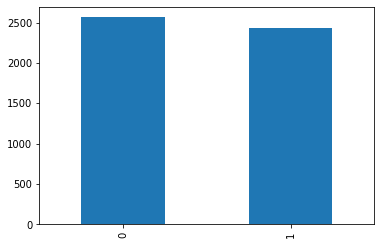

In [ ]:
train['label'].value_counts().plot(kind='bar')

In [ ]:
#nunique() -> 겹치는 데이터 찾기.
train['document'].nunique()

5000

In [ ]:
train.isna().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
# 한글과 공백을 제외하고 모두 제거 (정규표현식 활용)
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train['document'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [ ]:
train.head()

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0


In [ ]:
# 한글과 공백을 제외하고 모두 제거 (정규표현식 활용)
test['document'] = test['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test['document'].replace('', np.nan, inplace=True)
print(test.isnull().sum())

id          0
document    0
dtype: int64


In [ ]:
test.head()

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱
2,3,
3,4,멋있는 영화입니다 잊을 수 없는
4,5,너무 감동적이네요 펑펑 울었습니다


## 토큰화


In [ ]:
train_data = train
test_data = test

In [ ]:
# 토큰화를 위해 형태소 분석기를 사용합니다.
mecab = Mecab()
print(mecab.morphs(train.iloc[0, 1]))

['영상', '이나', '음악', '이', '이쁘', '다', '해도', '미', '화', '시킨', '불륜', '일', '뿐']


In [ ]:
# from konlpy.tag import Twitter
# mecab = Twitter()
# print(mecab.morphs(train.iloc[0, 1]))

In [ ]:
# 불용어를 정의합니다. (불용어를 더 추가해도 됩니다.)
stopwords = ['도', '는', '다', '의', '가', '이',
             '은', '한', '에', '하', '고', '을',
             '를', '인', '듯', '과', '와', '네',
             '들', '듯', '지', '임', '게']

In [ ]:
# 불용어를 제거하여 불필요한 토큰을 제거합니다. 
train_data['tokenized'] = train['document'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
train_data.head()

,id,document,label,tokenized
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,"[영상, 이나, 음악, 이쁘, 해도, 미, 화, 시킨, 불륜, 일, 뿐]"
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯,1,"[히치콕, 영화, 봤, 다면, 분명, 박수, 쳤]"
2,3,괜찮은 음악영화가 또 나왔군요 따뜻한 겨울이 될 것 같아요,1,"[괜찮, 음악, 영화, 또, 나왔, 군요, 따뜻, 겨울, 될, 것, 같, 아요]"
3,4,아무래도 년도지난작품이라 지금보기는너무유치하다,0,"[아무래도, 년, 지난, 작품, 라, 지금, 보, 기, 너무, 유치]"
4,5,지금까지의 영화들이 그랬듯 이 영화역시 일본에 대한 미화는 여전하다,0,"[지금, 까지, 영화, 그랬, 영화, 역시, 일본, 대한, 미화, 여전]"


In [ ]:
# 불용어를 제거하여 불필요한 토큰을 제거합니다. 
test_data['tokenized'] = test['document'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test.head()

,id,document,tokenized
0,1,시간 때우기 좋은 영화 지루함,"[시간, 때우, 기, 좋, 영화, 지루함]"
1,2,훈훈한 정이 느껴지는 영화 가족끼리 드라마 보듯이 보면 딱,"[훈훈, 정, 느껴, 영화, 가족, 끼리, 드라마, 보, 듯이, 보, 면, 딱]"
2,3,,[]
3,4,멋있는 영화입니다 잊을 수 없는,"[멋있, 영화, 입니다, 잊, 수, 없]"
4,5,너무 감동적이네요 펑펑 울었습니다,"[너무, 감동, 적, 네요, 펑펑, 울, 었, 습니다]"


## Train/Test

In [ ]:
# train_data의 tokenized 컬럼의 값을 x_train에 저장하세요.
x_train = train_data['tokenized']

# train_data의 label 컬럼의 값을 y_train에 저장하세요.
y_train = train_data['label']

print(x_train)
# x_train과 y_train 변수를 numpy array로 변환하세요.
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train)

0            [영상, 이나, 음악, 이쁘, 해도, 미, 화, 시킨, 불륜, 일, 뿐]
1                         [히치콕, 영화, 봤, 다면, 분명, 박수, 쳤]
2        [괜찮, 음악, 영화, 또, 나왔, 군요, 따뜻, 겨울, 될, 것, 같, 아요]
3              [아무래도, 년, 지난, 작품, 라, 지금, 보, 기, 너무, 유치]
4            [지금, 까지, 영화, 그랬, 영화, 역시, 일본, 대한, 미화, 여전]
                            ...                      
4995                     [좋, 배우, 로, 류영화, 찍, 안타까운, 영화]
4996    [진짜, 드럽, 재미없, 에드워드, 호퍼, 그림, 배경, 빼, 볼, 아닌, 영화]
4997              [가장, 실망, 스러운, 영화, 지금, 까지, 본, 영화, 중]
4998          [이런, 평점, 테러, 네이버, 에서, 좀, 막, 아야, 것, 아닌가]
4999       [여주인공, 전작, 에서, 귀여웠, 는데, 여기, 선, 완전, 망했, 실망]
Name: tokenized, Length: 5000, dtype: object
[list(['영상', '이나', '음악', '이쁘', '해도', '미', '화', '시킨', '불륜', '일', '뿐'])
 list(['히치콕', '영화', '봤', '다면', '분명', '박수', '쳤'])
 list(['괜찮', '음악', '영화', '또', '나왔', '군요', '따뜻', '겨울', '될', '것', '같', '아요'])
 ... list(['가장', '실망', '스러운', '영화', '지금', '까지', '본', '영화', '중'])
 list(['이런', '평점', '테러', '네이버', '에서', '좀', '막', '아야', '것', '아닌가'])
 list(['여주인공', '전작', '에서', '귀여웠', 

In [ ]:
# test_data의 tokenized 컬럼의 값을 x_test에 저장하세요.
x_test = train_data['tokenized']

# test_data의 label 컬럼의 값을 y_test에 저장하세요.
y_test = train_data['label']

# x_train과 y_train 변수를 numpy array로 변환하세요.
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
xv_train = x_train
yv_train = y_train
xv_test = x_test
yv_test = y_test

In [ ]:
xv_train

array([list(['영상', '이나', '음악', '이쁘', '해도', '미', '화', '시킨', '불륜', '일', '뿐']),
       list(['히치콕', '영화', '봤', '다면', '분명', '박수', '쳤']),
       list(['괜찮', '음악', '영화', '또', '나왔', '군요', '따뜻', '겨울', '될', '것', '같', '아요']),
       ..., list(['가장', '실망', '스러운', '영화', '지금', '까지', '본', '영화', '중']),
       list(['이런', '평점', '테러', '네이버', '에서', '좀', '막', '아야', '것', '아닌가']),
       list(['여주인공', '전작', '에서', '귀여웠', '는데', '여기', '선', '완전', '망했', '실망'])],
      dtype=object)

In [ ]:
#Test Data Tokenize
test_tokenize = test_data['tokenized']

In [ ]:
# Tokenizer를 생성
tokenizer = Tokenizer()
tokenizer

# -> Tokenizer를 다른거를 써보자!!

# TfidfVectorizer , Tokenizer, CounterVectorizer

In [ ]:
# # Tokenizer를 생성
# tokenizer = Tokenizer()
# tokenizer

# -> Tokenizer를 다른거를 써보자!!

# TfidfVectorizer , Tokenizer, CounterVectorizer

In [ ]:
# # Tokenizer를 생성
# from sklearn.feature_extraction.text import TfidfVectorizer
# tokenizer = TfidfVectorizer()
# tokenizer

In [ ]:
# fit_on_texts 함수를 이용하여 x_train을 피팅하세요.
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(test_tokenize)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10616
등장 빈도가 1번 이하인 희귀 단어의 수: 5873
단어 집합에서 희귀 단어의 비율: 55.322155237377544
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.346719114722919


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4745


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(x_train)

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
test_tokenize = tokenizer.texts_to_sequences(test_tokenize)

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [ ]:
x_train = pad_sequences(x_train, maxlen = max_len)
x_test = pad_sequences(x_test, maxlen = max_len)
test_tokenize = pad_sequences(test_tokenize, maxlen = max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(rate=0.05))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(rate=0.05))
model.add(GRU(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         474500    
                                                                 
 gru (GRU)                   (None, None, 128)         88320     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, None, 128)         99072     
                                                                 
 dropout_1 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, mode='auto'),       

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc, rl], batch_size=30, validation_split=0.1)

Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 0.4424 - acc: 0.7778
Epoch 00001: val_acc improved from -inf to 0.81000, saving model to best_model.h5
150/150 [==============================] - 35s 198ms/step - loss: 0.4424 - acc: 0.7778 - val_loss: 0.4674 - val_acc: 0.8100 - lr: 0.0010
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 0.2445 - acc: 0.8996
Epoch 00002: val_acc improved from 0.81000 to 0.83800, saving model to best_model.h5
150/150 [==============================] - 29s 190ms/step - loss: 0.2445 - acc: 0.8996 - val_loss: 0.3658 - val_acc: 0.8380 - lr: 0.0010
Epoch 3/15
150/150 [==============================] - ETA: 0s - loss: 0.1823 - acc: 0.9287
Epoch 00003: val_acc improved from 0.83800 to 0.85800, saving model to best_model.h5
150/150 [==============================] - 29s 192ms/step - loss: 0.1823 - acc: 0.9287 - val_loss: 0.3817 - val_acc: 0.8580 - lr: 0.0010
Epoch 4/15
150/150 [==============================] - ETA: 0s - 

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

157/157 [==============================] - 10s 58ms/step - loss: 0.1442 - acc: 0.9468

 테스트 정확도: 0.9468


In [ ]:
y_pred = loaded_model.predict(x_test)

In [ ]:
test_pred = loaded_model.predict(test_tokenize)

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i] < 0.5:
    y_pred[i] = 0
  else:
    y_pred[i]=1

In [ ]:
for i in range(len(test_pred)):
  if test_pred[i] < 0.5:
    test_pred[i] = 0
  else:
    test_pred[i]=1

In [ ]:
ACCURACY(y_pred, y_test)
#50008704
#50054784
#50064--- -> 100 64 128
#5012---- -> 100 64 Drop 128

0.5006144

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

99.91% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('이 상품 진짜 애매해... 저는 보류합니다...')

62.92% 확률로 긍정 리뷰입니다.


In [ ]:
test_pred

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [ ]:
sample_submission['label'] = test_pred
sample_submission.to_csv("GRU_Tune.csv", index=False)


## 머산러닝을 이용하여 예측을 해본다면?

In [ ]:
#분류/Classifier 사용에 필요한 모델 import 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier


In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10,random_state=0,shuffle = True)
# scoring = 'F1_score'
# cv_results = cross_val_score(model,x_train,y_train,cv= kfold, scoring = 'f1')
# cv_results.mean()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

kfold = KFold(n_splits=10,random_state=7,shuffle = True)
scoring = 'F1_score'


models=[RandomForestClassifier(random_state=0), KNeighborsClassifier(), BaggingClassifier(random_state=0),
        GradientBoostingClassifier(random_state=0), 
        XGBClassifier(random_state=0),
        LGBMClassifier(random_state=0),
        AdaBoostClassifier(random_state=0),  SVC(), SGDClassifier(),
        ]
     
model_names=['RandomForest', 'KNeighbors', 'Bagging', 'GradientBoosting', 'XGB', 'LGBM',
             'AdaBoost', 'SVC', 'SGD', 
          ]

for model in range (len(models)):
    clf=models[model]
    # clf.fit(x_train,y_train)
    # test_pred=clf.predict(x_test)

    # test_pred = test_pred.reshape(-1,1)
    # y_test_pred = y_test.reshape(-1,1)

    cv_results = cross_val_score(clf,x_train,y_train,cv= kfold, scoring = 'f1')

    
    # acc = accuracy_score(y_test_pred, test_pred)
    print("model : " ,clf , "\tMean_f1_score : ",cv_results.mean())

    # print(clf.score(y_test.reshape(-1,1), test_pred))

    # y_test_sex = np.array(y_test)
    # print(models[model])
    # print(test_pred - y_test_sex)


model :  RandomForestClassifier(random_state=0) 	Mean_f1_score :  0.5347644023335508
model :  KNeighborsClassifier() 	Mean_f1_score :  0.493840194796819
model :  BaggingClassifier(random_state=0) 	Mean_f1_score :  0.5073095959877049
model :  GradientBoostingClassifier(random_state=0) 	Mean_f1_score :  0.5783564075924813
model :  XGBClassifier() 	Mean_f1_score :  0.5832605856831142
model :  LGBMClassifier(random_state=0) 	Mean_f1_score :  0.6087546714027355
model :  AdaBoostClassifier(random_state=0) 	Mean_f1_score :  0.5576790464933538
model :  SVC() 	Mean_f1_score :  0.52828779717851
model :  SGDClassifier() 	Mean_f1_score :  0.49441698749438945


In [ ]:
model_LGBM = LGBMClassifier(random_state=0).fit(x_train, y_train)
test_fin = model_LGBM.predict(test_tokenize)
test_fin

array([1, 1, 1, ..., 1, 1, 0])

In [ ]:
sample_submission['label'] = test_fin
sample_submission.to_csv("LSTM_Tune.csv", index=False)


## 튜닝

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {
    "n_estimators" : [1800],
    # 'num_leaves': [2,3,4,5,6,7,8,9,10],
    # 'reg_lambda' : [2,3,4,5],
    'n_jobs' : [-1],
    'learning_rate': [0.1, 0.05, 0.01, 0.2],
    }
    
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(XGBClassifier(random_state=0), parameters, verbose=2, cv=5)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ....learning_rate=0.1, n_estimators=1800, n_jobs=-1; total time=  15.2s
[CV] END ....learning_rate=0.1, n_estimators=1800, n_jobs=-1; total time=  15.1s
[CV] END ....learning_rate=0.1, n_estimators=1800, n_jobs=-1; total time=  15.1s
[CV] END ....learning_rate=0.1, n_estimators=1800, n_jobs=-1; total time=  15.3s
[CV] END ....learning_rate=0.1, n_estimators=1800, n_jobs=-1; total time=  15.1s
[CV] END ...learning_rate=0.05, n_estimators=1800, n_jobs=-1; total time=  15.0s
[CV] END ...learning_rate=0.05, n_estimators=1800, n_jobs=-1; total time=  15.0s
[CV] END ...learning_rate=0.05, n_estimators=1800, n_jobs=-1; total time=  15.1s
[CV] END ...learning_rate=0.05, n_estimators=1800, n_jobs=-1; total time=  15.1s
[CV] END ...learning_rate=0.05, n_estimators=1800, n_jobs=-1; total time=  15.0s
[CV] END ...learning_rate=0.01, n_estimators=1800, n_jobs=-1; total time=  14.9s
[CV] END ...learning_rate=0.01, n_estimators=1800

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01, 0.2],
                         'n_estimators': [1800], 'n_jobs': [-1]},
             verbose=2)

In [ ]:
grid.best_params_ , grid.best_score_

({'learning_rate': 0.2, 'n_estimators': 1800, 'n_jobs': -1}, 0.6594)

In [ ]:
kfold = KFold(n_splits=10,random_state=7,shuffle = True)
scoring = 'F1_score'
cv_results = cross_val_score(XGBClassifier(random_state=0, learning_rate=0.2, n_estimators=1800, n_jobs=-1) 
    ,x_train,y_train,cv= kfold, scoring = 'f1')
cv_results.mean()

0.6538759392845532

In [ ]:
6174

6174

In [ ]:
from sklearn.neural_network import MLPClassifier # 모델 불러오기
model_mlp = MLPClassifier() # 객체에 모델 할당
model_mlp.fit(x_train, y_train) # 모델 학습

MLPClassifier()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10,random_state=0,shuffle = True)
scoring = 'F1_score'
cv_results = cross_val_score(model_mlp,x_train,y_train,cv= kfold, scoring = 'f1')
cv_results.mean()

0.5238094700537823

## 이번에는 TfidfVectorizer 사용해보기


In [ ]:
# Tokenizer를 생성
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer()

In [ ]:
xv = train_data['document']
yv = np.array(train_data.label)
# xv_test = test_data['document']
# yv_train = test_data['document']


In [ ]:
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_features=15800)

In [ ]:
x_vector = vectorizer.fit_transform(xv)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_vector, yv, test_size=0.2, random_state=2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import SGDClassifier

In [ ]:
SVM = svm.SVC().fit(x_train, y_train)
KNN = KNeighborsClassifier(n_neighbors = 47).fit(x_train, y_train)
LR = LogisticRegression(class_weight='balanced', max_iter=1000).fit(x_train, y_train)
RFC = RandomForestClassifier(class_weight='balanced', n_estimators=1000).fit(x_train, y_train)
GBC = GradientBoostingClassifier(n_estimators=1000).fit(x_train, y_train)
XGB = XGBClassifier(class_weight='balanced', n_estimators=1800).fit(x_train, y_train)
LGBM = LGBMClassifier(class_weight='balanced', n_estimators=1000).fit(x_train, y_train)

In [ ]:
XGB = XGBClassifier(class_weight='balanced', n_estimators=1000).fit(x_train, y_train)
ADA = AdaBoostRegressor().fit(x_train, y_train)
Bagging = BaggingRegressor().fit(x_train, y_train)
SGD = SGDClassifier().fit(x_train, y_train)

In [ ]:
SVM1 = svm.SVC(kernel='poly').fit(x_train, y_train)
SVM2 = svm.SVC(kernel='rgb').fit(x_train, y_train)
# SVM3 = svm.SVC(kernel='poly').fit(x_train, y_train)
# SVM4 = svm.SVC(kernel='poly').fit(x_train, y_train)


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'kernel' : ['rbf'],
    'gamma' : [2,3,4,5],
    # 'C' : [0.01, 0.1, 1, 10], 
    # 'epsilon' : [0.01, 0.1, 0, 1, 10],
    # 'coef0' : [0.001, 0.01, 0.1, 0, 1, 10]
    }
#verbose = 2 -> Grid Search 반복시 하이퍼 파라메타별 메시지를 화면에 출력 
#cv=5 5번의 교차검증.
grid = GridSearchCV(svm.SVC(), parameters, verbose=2, cv=5)
grid.fit(x_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ................................gamma=2, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=2, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=2, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=2, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=2, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=3, kernel=rbf; total time=   5.8s
[CV] END ................................gamma=3, kernel=rbf; total time=   5.8s


In [ ]:
grid.best_params_

In [ ]:
print(f"max_features: {15800}\
  , SVM: {SVM.score(x_test, y_test)}\
  , KNN: {KNN.score(x_test, y_test)}\
  , LR: {LR.score(x_test, y_test)}\
  , RFC: {RFC.score(x_test, y_test)}\
  , GBC: {GBC.score(x_test, y_test)}\
  , XGB: {XGB.score(x_test, y_test)}, \
  LGBM: {LGBM.score(x_test, y_test)}\
  " )

max_features: 15800  , SVM: 0.888  , KNN: 0.837  , LR: 0.878  , RFC: 0.845  , GBC: 0.859  , XGB: 0.832,   LGBM: 0.829  


In [ ]:
print(f"max_features: {15800}\
  , ADA: {ADA.score(x_test, y_test)}\
  , XGB: {XGB.score(x_test, y_test)}\
  , Bagging: {Bagging.score(x_test, y_test)}\
  , SGD: {RFC.score(x_test, y_test)}\
  " )

max_features: 15800  , ADA: 0.05673741896033302  , XGB: 0.844  , Bagging: 0.41417019114193  , SGD: 0.845  


In [ ]:
for train_index, test_index in kf.split(data_x, data_y):
   x_train, x_test = data_x[train_index], data_x[test_index]
   y_train, y_test = data_y[train_index], data_y[test_index]

   tfidf = TfidfVectorizer()
   x_train = tfidf.fit_transform(x_train)
   x_test = tfidf.transform(x_test)

   clf = SVC()
   clf.fit(x_train, y_train)
   y_pred = clf.predict(x_test)
   score = accuracy_score(y_test, y_pred)
   print(score)